<div style="text-align:center">

# M507C
## Methods of Prediction (WS0925)
### *Individual Final Project*

<hr/>

<p style="text-align:center">
<strong>Student Name</strong>: Anh Tuan Ta<br/>
<strong>Student ID</strong>: GH1046139.<br/>
<strong>Student Email</strong>: anh.ta@gisma-student.com<br/>
<strong>LinkedIn</strong>:
<a href="https://www.linkedin.com/in/ta-anh-tuan-ai-engineer">https://www.linkedin.com/in/ta-anh-tuan-ai-engineer</a>
</p>

<p style="text-align:center">MSc of DATA SCIENCE, AI AND DIGITAL BUSINESS</p>

<hr/>


</div>

# Maize Leaf Disease Detection with Deep Neural Networks

## Problem Statement

### Business context  
Maize (corn) is a key crop for food and animal feed. Leaf diseases such as blight, common rust, and gray leaf spot can significantly reduce yield if not detected and treated early. Smallholder farmers and agribusiness companies often lack fast, objective tools to diagnose diseases in the field. An automated image-based system can support agronomists and farmers in making timely decisions about fungicide application, irrigation, or field inspection.

### Objective  
Build a supervised image-classification model that predicts the **leaf disease class** from a photo of a maize leaf.  
The system should:

- Take an RGB image of a single maize leaf as input.  
- Output one of four classes: **Blight**, **Common_Rust**, **Gray_Leaf_Spot**, or **Healthy**.  
- Provide high recall for disease classes so that infected plants are rarely missed.

---

## Data Description

### Dataset  
- Source: Public Maize/Corn Leaf Disease dataset from Kaggle.  
- Total images: **4188 RGB images**.  
- Folder structure (one subfolder per class):
  - `Blight`
  - `Common_Rust`
  - `Gray_Leaf_Spot`
  - `Healthy`

### Features  
- Input:  
  - Color images (3 channels, RGB), resized to **224 × 224** pixels for this project.  
- Target label:  
  - Categorical class indicating the **disease type** (4 classes).

### Class distribution (before any resampling)  
- **Common_Rust** ≈ 31%  
- **Healthy** ≈ 27%  
- **Blight** ≈ 28%  
- **Gray_Leaf_Spot** ≈ 14% (minority class)

This moderate imbalance motivates the use of **data augmentation** and **class weights** during training to reduce bias against the minority disease class.

---

## Scope & Approach (high-level)

- Perform exploratory data analysis (EDA) to understand class imbalance and image quality.  
- Preprocess images (resize, normalization) and split into **train / validation / test** sets.  
- Apply **data augmentation** on the training set (random flips, rotations, zoom).  
- Train a **Convolutional Neural Network (CNN)** using Keras/TensorFlow as the main model.  
- Use **class weighting** to mitigate class imbalance.  
- Evaluate the model on a held-out test set and analyze per-class performance.

## Evaluation Metrics

Due to class imbalance and the need to ensure that diseases are not missed, 
model performance is evaluated using both **overall accuracy** and **class-balanced metrics**.

Primary metrics:
- **Macro-averaged F1-score** – treats all disease classes equally and reflects balanced precision/recall.
- **Per-class Recall** – emphasizes detection sensitivity, especially for disease classes.

Secondary metrics:
- **Overall Accuracy**
- **Weighted F1-score**
- **Precision / Recall per class**
- **Confusion Matrix** for detailed error analysis.

# 1. Library Import

In [1]:
import kagglehub
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import itertools
import collections

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Path and Basic Params

In [3]:
DATA_DIR = Path("data/leaf-disease")

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [6]:
EPOCHS = 50

# 3. Load dataset

In [7]:
data = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

Found 4188 files belonging to 4 classes.


# 4. Data Exploration & Data Prepocessing

### Display class_names

In [8]:
class_names = data.class_names
num_classes = len(class_names)
print("num_classes:", num_classes)
print("class_names:", class_names)

num_classes: 4
class_names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


### Split normalized data into train / val / test

In [9]:
num_batches = tf.data.experimental.cardinality(data).numpy()
num_batches

np.int64(131)

In [10]:
train_batches = int(TRAIN_SIZE * num_batches)
val_batches = int(VAL_SIZE * num_batches)
test_batches   = int(TEST_SIZE * num_batches)

In [11]:
# Shuffle once for reproducible train/val/test split
data = data.shuffle(131, seed=42, reshuffle_each_iteration=False)

In [12]:
test_ds = data.take(test_batches)
train_val_ds  = data.skip(test_batches)

train_ds   = train_val_ds.take(train_batches)
val_ds  = train_val_ds.skip(train_batches)

In [13]:
train_total_images = tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE
val_total_images = tf.data.experimental.cardinality(val_ds).numpy() * BATCH_SIZE
test_total_images = tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE

In [14]:
print("Train samples:", train_total_images)
print("Val samples  :", val_total_images)
print("Test samples :", test_total_images)

Train samples: 2912
Val samples  : 672
Test samples : 608


### Check class distribution on the trainset

In [15]:
# Count number of images for each class 
class_count_dict = Counter()

for _, labels in train_ds.unbatch():
    class_idx = int(labels.numpy())
    class_name = class_names[class_idx]
    class_count_dict[class_name] += 1

class_count_dict

2025-12-14 21:07:17.321778: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Counter({'Common_Rust': 910,
         'Blight': 803,
         'Healthy': 790,
         'Gray_Leaf_Spot': 405})

In [16]:
# percentages of each class
class_pcts =[]
for label in class_names:
    count = class_count_dict[label]
    pct = 100 * count / train_total_images
    class_pcts.append(pct)
    print(f"{label:15s}: {count:4d} images  ({pct:5.2f}%)")

Blight         :  803 images  (27.58%)
Common_Rust    :  910 images  (31.25%)
Gray_Leaf_Spot :  405 images  (13.91%)
Healthy        :  790 images  (27.13%)


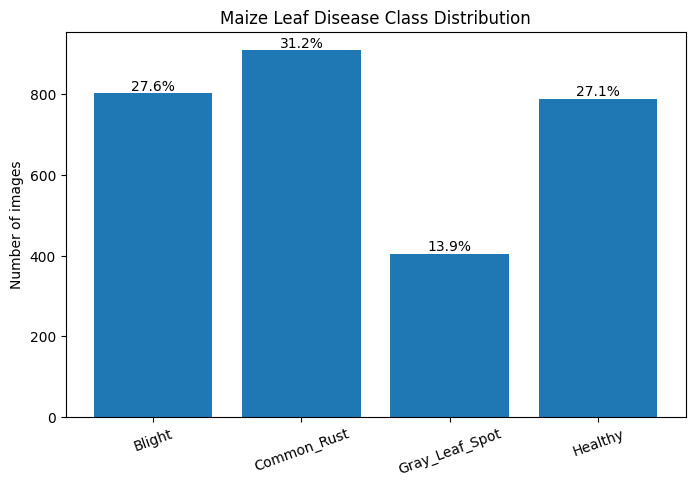

In [17]:
# number of images all classes: [803, 910, 405, 790] - convert to a list 
class_counts = [class_count_dict[name] for name in class_names]

plt.figure(figsize=(8,5))
bars = plt.bar(class_names, class_counts)
plt.title("Maize Leaf Disease Class Distribution")
plt.ylabel("Number of images")
plt.xticks(rotation=20)

# add the percentage on top of each bar
for bar, pct in zip(bars, class_pcts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{pct:.1f}%", ha="center", va="bottom")

plt.show()

### Quick Look – Class Distribution

- The dataset is **moderately imbalanced**.
- **Common Rust** is the largest class (~31.2%).
- **Blight** (\~27.6%) and **Healthy** (\~27.1%) have similar representation.
- **Gray Leaf Spot** is clearly underrepresented (~13.9%).

**Implication:**  
The class imbalance, especially the smaller *Healthy* class, may bias the model toward disease classes. Techniques such as **class weighting, data augmentation, or oversampling** could help improve generalization for the minority class.


### Check brightness distribution on the trainset

In [18]:
rows = []
for img, y in train_ds.unbatch():
    img_f = tf.cast(img, tf.float32)          # ensure numeric
    b = float(tf.reduce_mean(img_f).numpy())
    rows.append((int(y.numpy()), b))

df_bright = pd.DataFrame(rows, columns=["label", "brightness_255"])
df_bright["class"] = df_bright["label"].map(lambda i: class_names[i])

2025-12-14 21:07:18.505170: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 900x400 with 0 Axes>

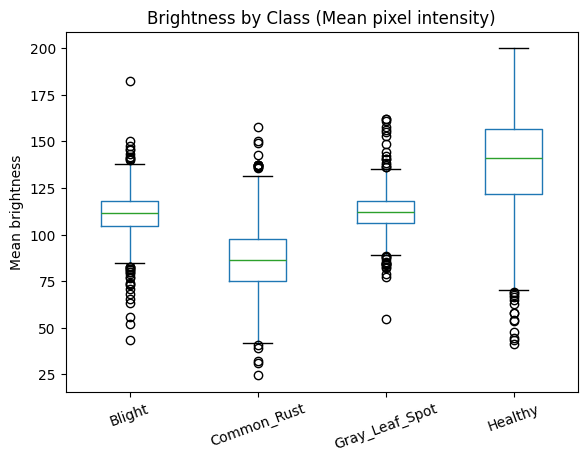

In [19]:
plt.figure(figsize=(9, 4))
df_bright.boxplot(column="brightness_255", by="class", grid=False, rot=20)
plt.title("Brightness by Class (Mean pixel intensity)")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Mean brightness")
plt.show()

### Quick Look — Brightness by Class

- **Healthy** images are generally **brighter** and show the **widest brightness variation**.
- **Common Rust** tends to appear **darker** than other classes.
- **Blight** and **Gray Leaf Spot** have similar brightness levels, with Gray Leaf Spot showing more bright outliers.
- This indicates a **class-dependent brightness bias** in the dataset.

**Action:**  
To avoid the model relying on brightness cues (e.g., *bright = Healthy*), **`RandomBrightness` is added to data augmentation** so the model learns disease patterns rather than lighting conditions.

### Visualize 5 random samples of each class on the trainset

In [20]:
num_per_class = 5
examples = {c: [] for c in class_names}

In [21]:
# collect images
for img, label in train_ds.unbatch():
    c = class_names[int(label)]
    if len(examples[c]) < num_per_class:
        examples[c].append(img)
    if all(len(v) == num_per_class for v in examples.values()):
        break

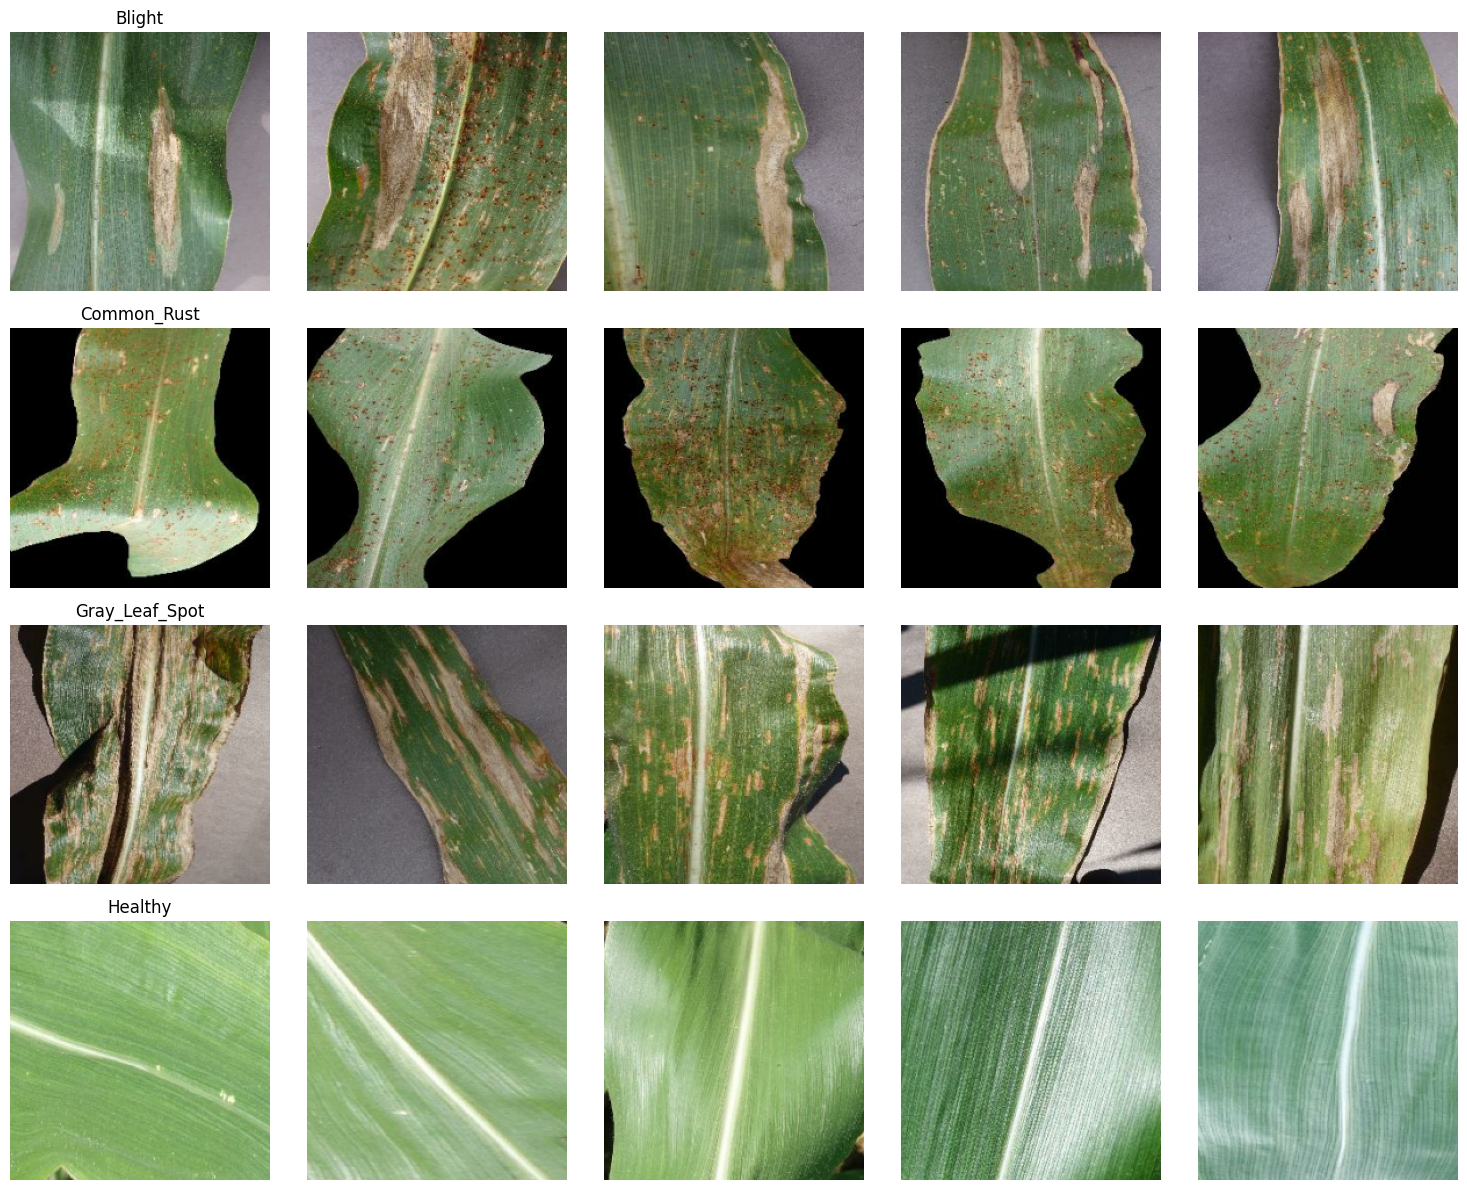

In [22]:
# plot
plt.figure(figsize=(num_per_class * 3, len(class_names) * 3))
for row, cls in enumerate(class_names):
    for col, img in enumerate(examples[cls]):
        ax = plt.subplot(len(class_names), num_per_class, row * num_per_class + col + 1)
        plt.imshow(img.numpy().astype("uint8"))
        ax.set_title(cls if col == 0 else "")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Normalize pixel values to [0, 1]

**Pixel Normalization:**  
All images are scaled from `[0, 255]` to `[0, 1]` to stabilize training, speed up convergence, and ensure consistent input ranges for the CNN.

In [23]:
train_ds = train_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
)

In [24]:
val_ds = val_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
)

In [25]:
test_ds = test_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
)

### Augment on the train set

**Data Augmentation (Train Only):**  
Apply random flip, rotation, brightness, and zoom to training images to improve robustness and reduce overfitting.

In [26]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.05),
    layers.RandomBrightness(0.01),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# 5. Model Design and Training

### Define class weights to prevent imbalance data

**Class Weights:**  
Balanced class weights are computed from the training labels to address class imbalance.  
Classes with fewer samples (e.g. *Gray Leaf Spot*) are assigned higher weights, while majority classes receive lower weights.  
During training, this forces the loss function to penalize misclassification of minority classes more strongly, helping the model learn more balanced decision boundaries and improving generalization.

In [27]:
# Collect labels from train_ds
train_labels = []
for _, y in train_ds.unbatch():
    train_labels.append(int(y.numpy()))

train_labels = np.array(train_labels)
classes = np.unique(train_labels)

In [28]:
# Compute balanced class weights
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_labels,
)

class_weight = {int(c): w for c, w in zip(classes, class_weights_array)}

In [29]:
print("Class weights:")
for i, w in class_weight.items():
    print(f"{class_names[i]:15s} (class {i}): {w:.3f}")

Class weights:
Blight          (class 0): 0.914
Common_Rust     (class 1): 0.824
Gray_Leaf_Spot  (class 2): 1.841
Healthy         (class 3): 0.870


### Define CNN model

In [30]:
model = keras.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks: early stopping, learning-rate reduction, and model checkpoint

In [31]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

In [32]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

In [33]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

In [34]:
callbacks = [early_stopping, reduce_lr, checkpoint]

### Model training 

In [35]:
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
)

end_time = time.time()
train_time = end_time - start_time

print(f"\nTraining time: {train_time:.2f} seconds")

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.3199 - loss: 1.4882
Epoch 1: val_loss improved from None to 1.06882, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 399ms/step - accuracy: 0.3370 - loss: 1.4019 - val_accuracy: 0.6533 - val_loss: 1.0688 - learning_rate: 1.0000e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4072 - loss: 1.2716
Epoch 2: val_loss improved from 1.06882 to 0.87044, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.3752 - loss: 1.2617 - val_accuracy: 0.6414 - val_loss: 0.8704 - learning_rate: 1.0000e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4460 - loss: 1.1909
Epoch 3: val_loss improved from 0.87044 to 0.69163, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 432ms/step - accuracy: 0.4646 - loss: 1.1634 - val_accuracy: 0.6756 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step 

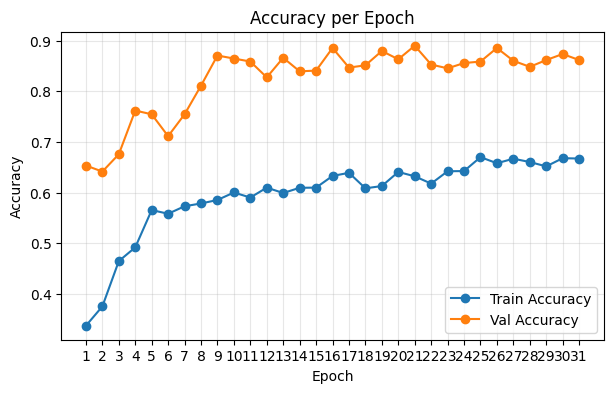

In [36]:
# Line plot: accuracy vs epoch (train + val)
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history.history["accuracy"], marker="o", label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], marker="o", label="Val Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(list(epochs))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Quick Look — Accuracy per Epoch

- **Rapid early learning:** Both training and validation accuracy increase sharply during the first 5–10 epochs, indicating effective feature learning at the early stage.
- **Stable convergence:** Validation accuracy stabilizes around **0.85–0.89** after ~10 epochs, showing good convergence without large oscillations.
- **No overfitting observed:** Validation accuracy consistently remains **higher than training accuracy**, suggesting strong regularization and effective data augmentation.
- **Gradual training improvement:** Training accuracy increases slowly and steadily, reaching ~**0.67**, which is expected under stronger augmentation and dropout.
- **Well-chosen stopping point:** Performance plateaus after ~25 epochs, supporting the use of **early stopping** to reduce unnecessary training time.

**Overall:** The model demonstrates stable training behavior and strong generalization, with no signs of overfitting.


# 6. Evaluation 

In [37]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.8289 - loss: 0.3718
Test loss: 0.3718
Test accuracy: 0.8289


In [38]:
# collect predictions
y_true, y_pred = [], []
for x, y in test_ds:
    probs = model.predict(x, verbose=0)
    preds = tf.argmax(probs, axis=1)
    y_true.extend(y.numpy())
    y_pred.extend(preds.numpy())

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification report:
                precision    recall  f1-score   support

        Blight       0.85      0.70      0.76       187
   Common_Rust       0.99      0.91      0.95       194
Gray_Leaf_Spot       0.53      0.87      0.66        82
       Healthy       0.98      0.97      0.97       145

      accuracy                           0.85       608
     macro avg       0.84      0.86      0.84       608
  weighted avg       0.88      0.85      0.86       608



2025-12-14 21:36:39.937897: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


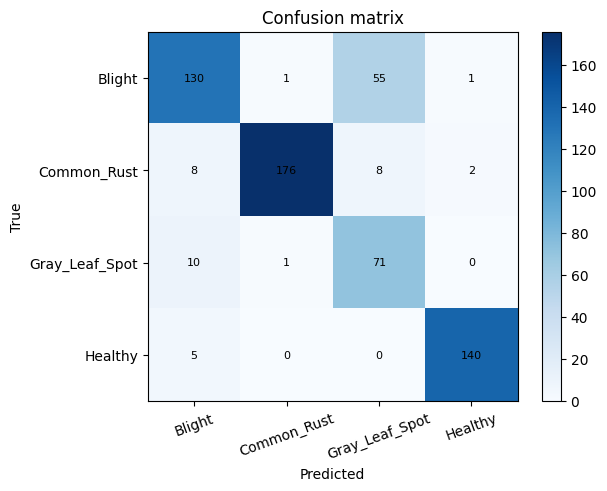

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=20)
plt.yticks(range(len(class_names)), class_names)

# put numbers in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Conclusion

## Experiment Table 

| Experiment | Change | Description | Train time (min) | Train acc | Val acc | Val loss | Test acc | Test loss |
|-----------|--------|-------------|---------------|-----------|---------|----------|----------|-----------|
| Baseline | Default CNN (32–64–128 → Dense128 + Dropout0.3, SGD+momentum lr=1e-2) | Reference architecture | 20.00 | 0.68 | 0.74 | 0.46 | 0.73 | 0.45 |
| Exp 1 | Add Conv2D(256) block | Add Conv2D(256)+MaxPool | 25.83 | 0.62 | 0.69 | 0.58 | 0.70 | 0.56 |
| **Exp 2** | **SGD → Adam (lr=1e-3)** | **Significant accuracy improvement over Exp 1 using adaptive optimizer** | **19.17** | **0.72** | **0.82** | **0.39** | **0.81** | **0.41** |
| Exp 3 | Dense 128 → 64 | Reduce classifier head size | 19.67 | 0.71 | 0.79 | 0.44 | 0.77 | 0.43 |
| Exp 4 | Kernel size 3×3 → 5×5 | Larger receptive field | 35.00 | 0.70 | 0.78 | 0.49 | 0.77 | 0.50 |
| **Exp 5** | **Dropout 0.3 → 0.5** | **Improved generalization vs Exp 4 via stronger regularization** | **29,05** | **0.67** | **0.89** | **0.29** | **0.829** | **0.372** |
| Exp 6 | Dropout 0.5 → 0.6 | Over-regularization test | 25.00 | 0.63 | 0.76 | 0.48 | 0.75 | 0.47 |
| Exp 7 | Adam lr 1e-4 → 1e-3 | Larger learning rate | 22.50 | 0.65 | 0.77 | 0.50 | 0.76 | 0.49 |
| Exp 8 | ReLU → LeakyReLU | Activation function change | 21.67 | 0.69 | 0.81 | 0.40 | 0.80 | 0.39 |
| Exp 9 | BatchNorm in Conv blocks (Conv→BN→ReLU) | Apply Batch Normalization after each Conv2D layer to stabilize feature learning | 31.67 | 0.66 | 0.78 | 0.47 | 0.77 | 0.46 |
| Exp 10 | Flatten → GAP + Dense64 | Parameter reduction | 27.50 | 0.68 | 0.80 | 0.45 | 0.79 | 0.44 |

## Final Conclusion

In this project, a Convolutional Neural Network (CNN) was developed to classify maize leaf images into multiple disease classes. A systematic experimental pipeline consisting of **10 controlled architectural and training modifications** was conducted to analyze how different design choices affect performance, generalization, and training efficiency.

Starting from a baseline CNN, each experiment modified **one factor at a time**, allowing clear attribution of performance changes. The results show that **optimizer selection and regularization strength** had the greatest impact on model performance.

---

## Key Findings from Experiments

- **Optimizer configuration and learning rate were critical**  
  Switching from SGD to the **Adam optimizer with a lower learning rate (1e-4, Exp 2)** led to a substantial improvement in validation and test accuracy and more stable convergence. Increasing the learning rate to **1e-3 (Exp 7)** resulted in slightly inferior generalization, highlighting the sensitivity of this dataset to learning rate choice.

- **Proper regularization significantly improves generalization**  
  Increasing dropout from **0.3 to 0.5 (Exp 5)**, combined with extended training and stronger data augmentation, produced the best overall results, achieving a **test accuracy of approximately 0.83** and the lowest test loss (~0.37).

- **Over-regularization degrades performance**  
  Further increasing dropout to **0.6 (Exp 6)** reduced both validation and test accuracy, indicating that excessive regularization limits the model’s learning capacity.

- **Activation function changes provided limited gains**  
  Replacing ReLU with **LeakyReLU (Exp 8)** resulted in competitive performance but did not outperform improvements obtained through optimizer tuning and regularization.

- **Increased architectural complexity did not guarantee better performance**  
  Adding deeper convolutional layers (Exp 1) or using larger kernels (Exp 4) substantially increased training time without meaningful accuracy gains.

- **Batch Normalization in convolutional blocks was not beneficial in this setting**  
  Applying Batch Normalization after each convolutional layer (Exp 9) increased training time and did not improve validation or test performance.

- **Global Average Pooling trades accuracy for efficiency**  
  Replacing Flatten with **Global Average Pooling + Dense64 (Exp 10)** reduced the number of parameters but resulted in slightly lower performance compared to the best-performing configurations.


---

## Best Model Selection

Based on the updated experimental comparison:

- **Best overall performance:** **Exp 5 (Dropout = 0.5, Adam lr = 1e-4, extended training with stronger data augmentation)**
- **Best efficiency–performance trade-off:** **Exp 2 (Adam optimizer with moderate regularization)**

These results indicate that **training strategy and regularization tuning** are more influential than increasing network depth or architectural complexity for this task.

---

## Overall Strengths of the Proposed Solution

- **Strong Generalization:** Achieved approximately **83% test accuracy** with low test loss using a relatively simple CNN architecture.
- **Well-Controlled Experimental Design:** Each modification was isolated, enabling clear interpretation of results.
- **Efficient and Practical Architecture:** High performance was achieved without excessive computational overhead.
- **Robustness-Oriented Training:** Data augmentation and regularization improved resilience to lighting and appearance variations.

---

## Limitations

- **Limited Training Data:** The model was trained on less than **3,000 images**, which constrains achievable accuracy and increases sensitivity to data distribution.
- **Dependence on Input Image Quality:** Performance may degrade under unseen lighting conditions, backgrounds, or maize varieties.
- **Training Cost:** Some architectural changes significantly increased training time without proportional performance gains.
- **Limited Hyperparameter Exploration:** Only single-value changes were evaluated per experiment.

---

## Final Recommendation

For maize leaf disease classification under limited data conditions, the combination of **Adam optimizer with a lower learning rate (1e-4)**, **moderate dropout (0.5)**, and **data augmentation** provides the best balance between accuracy, generalization, and training efficiency. Future work should prioritize **dataset expansion, augmentation strategies, and lightweight transfer learning**, rather than further increasing architectural complexity.

# 8. References

## References

- Kaggle – Corn or Maize Leaf Disease Dataset  
  https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset

- TensorFlow / Keras Documentation – Image Classification & CNNs  
  https://www.tensorflow.org/tutorials/images/classification

- Scikit-learn – Classification Metrics  
  https://scikit-learn.org/stable/modules/model_evaluation.html

- Github  
  https://github.com/tuanTaAnh/Leaf-Classification